### Assignment description

The algorithm should be suitable to solve the problem, and should be clearly described. It should be able
to accept the predicted **Remaining Useful Lifetime (RULs)** for all engines as input, and output a valid maintenance solution for it. 

Such a solution should provide: 
(i) a list of all machines, indicating for any maintained machine the type of the team doing the maintenance, start-date, and end-date of the maintenance, as well as the penalty costs incurred by that machine;

(ii) the total penalty costs. It is not important here what the concrete cost of such a solution is, it just should be feasible. Make sure your solution format is easy to read and understand

**Input**: RUL predictions  (100 entries/rows)

**Output**: a list of all machines, indicating for any maintained machine the type of the team doing the maintenance, start-date, and end-date of the maintenance, as well as the penalty costs incurred by that machine; (ii) the total penalty costs. (100 entries/rows)

## Read the predicted RUL (that is our input) 
I do not understand why but they have one column which is separated by semicolon ...
We need to transform it into a better, more readable solution 

## Lecture 6 from Hendrik Baier;  evolutionary algorithms 

## Input 
So the id from the RUL is the id of the engine, right? If we take the 

RUL;id
135;1
125;2
...

Engine number 1 has 135 days left until it needs to be maintained and engine 2 has 125 days ect.

### First step in Genetic Algorithm: Population

- Individual is one possible solution 
- the population is the set of possible solutions



### Fitness evaluation
In our case fitness evaluation is the penalty cost. The smaller the penalty cost, the better



### Check termination criteria

As presented on the slide it is very often unknown, often some threshold is introduced.  From Q&A session I found out that there is not really a termination criteria, but we need to run an algorithm for some time (as described in the assignment description) 


### Selection of parents

From Q&A I know that this is 100% dependent on us. In DEAP package you can specify parameters to deal with parents

### Crossover
It depends on us, please check the DEAP package docs
###  Mutation
It depends on us, please check the DEAP package docs
### New offspring 
It depends on us, please check the DEAP package docs

## Output
a list of all machines, indicating for any maintained machine the type of the team doing the maintenance, start-date, and end-date of the maintenance, as well as the penalty costs incurred by that machine; (ii) the total penalty costs. (100 entries/rows)

## First create a random solution as a starting point?

## Lets start with the whole process by ourselves, I asked people and most of them coded the solution by themselves
## First we define the indiviudal and the population

## Fitness evaluation
### The lower the penalty cost for the whole individual the better

## Selection of parents
### The probability of selecting individual is directly proportional to its fitness value

# Starting with DEAP package
### If it is not installed, plase run the command below to run the DEAP python package

In [8]:
# pip install deap

     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     - -------------------------------------- 0.0/1.1 MB 281.8 kB/s eta 0:00:04
     -- ------------------------------------- 0.1/1.1 MB 363.1 kB/s eta 0:00:03
     ----------- ---------------------------- 0.3/1.1 MB 1.4 MB/s eta 0:00:01
     ------------------------ --------------- 0.7/1.1 MB 2.6 MB/s eta 0:00:01
     ------------------------ --------------- 0.7/1.1 MB 2.6 MB/s eta 0:00:01
     ------------------------------- -------- 0.8/1.1 MB 2.4 MB/s eta 0:00:01
     ---------------------------------------  1.1/1.1 MB 2.7 MB/s eta 0:00:01
     ---------------------------------------- 1.1/1.1 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for deap: filename=deap-1.4.1-py3-none-an

In [58]:
## READ CSV and filter the dates below the time of horizon
import os
import pandas as pd

# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current Working Directory:", current_directory)

# Define the time horizon
TIME_HORIZON = 30

# Read the CSV file into a DataFrame
df = pd.read_csv('predicted_RUL_dataset2.csv')

# Filter the DataFrame for rows where the RUL column is less than TIME_HORIZON
filtered_df = df[df['predicted_RUL'] < TIME_HORIZON]

# Display the filtered DataFrame
print(filtered_df)
print(f"Amount of engines needed to be repaired {len(filtered_df)}")


Current Working Directory: C:\Users\48504\Desktop\JADSMaster\PrescriptiveAlgorithms\Assignment3
    engine_id  predicted_RUL
23         24             29
30         31             19
34         35             12
55         56             14
65         66             16
67         68             29
75         76             26
80         81             20
90         91             15
91         92             21
Amount of engines needed to be repaired 10


In [69]:
import random
import numpy as np
import pandas as pd
from deap import algorithms, base, creator, tools
import matplotlib.pyplot as plt
import seaborn as sns

# Define constants
NUM_ENGINES = len(df)  
NUM_TEAMS_A = 2
NUM_TEAMS_B = 2
PLANNING_HORIZON = 30
MAX_DAILY_COST = 250

# Example maintenance times and engine costs 
maintenance_times_a = [4 if i < 20 else 3 if 20 <= i < 55 else 2 if 55 <= i < 80 else 8 for i in range(1, NUM_ENGINES + 1)]
maintenance_times_b = [time_a + 1 if i < 25 else time_a + 2 if 25 <= i < 70 else time_a + 1 for i, time_a in enumerate(maintenance_times_a, start=1)]
engine_costs = [4 if i < 21 else 3 if 21 <= i < 31 else 2 if 31 <= i < 46 else 5 if 46 <= i < 81 else 6 for i in range(1, NUM_ENGINES + 1)]


# Define fitness and individual classes
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Initialize the toolbox
toolbox = base.Toolbox()

# Attribute generator function to create multiple attributes
def create_individual():
    engine = filtered_df.sample().iloc[0]
    engine_id = engine['engine_id']
    team_allocated = random.choice(['A', 'B'])
    start_maintenance = random.randint(1, PLANNING_HORIZON * 2)
    
    if team_allocated == 'A':
        duration = maintenance_times_a[engine_id - 1]
    else:
        duration = maintenance_times_b[engine_id - 1]
    
    end_maintenance = start_maintenance + duration
    
    return {
        'engine_id': engine_id,
        'team_allocated': team_allocated,
        'start_maintenance': start_maintenance,
        'end_maintenance': end_maintenance,
        'cost': engine_costs[engine_id - 1],
        'safety_due_date': engine['predicted_RUL']  # Using RUL as safety_due_date
    }

# Register the individual generator
toolbox.register("individual", tools.initRepeat, creator.Individual, create_individual, len(filtered_df))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Create the population
pop = toolbox.population(n=1000)
print("Id")

def calculate_penalty_cost(individual):
    total_penalty = 0
    team_schedule = {
        'A1': [], 'A2': [],
        'B1': [], 'B2': []
    }
    
    days_team_start_count = {day: 0 for day in range(1, PLANNING_HORIZON * 2 + 1)}

    for engine in individual:
        start = engine['start_maintenance']
        end = engine['end_maintenance']
        team = engine['team_allocated']
        cost = engine['cost']
        safety_due_date = engine['safety_due_date']

        # Skip engines with RUL > PLANNING_HORIZON
        if safety_due_date > PLANNING_HORIZON:
            continue
        
        # Check if starting this task violates the constraint of max 4 teams per day
        if days_team_start_count[start] >= 4:
            penalty_cost = 500  # High penalty for violating team start constraint
        else:
            # Handle teams with multiple instances
            if team == 'A':
                available_team = None
                for team_instance in ['A1', 'A2']:
                    if all(end < s or start > e for s, e in team_schedule[team_instance]):
                        available_team = team_instance
                        break
                if available_team is None:
                    penalty_cost = 500  # High penalty for scheduling conflict
                else:
                    team_schedule[available_team].append((start, end))
                    if end > safety_due_date:
                        days_late = end - safety_due_date
                        penalty_cost = min(cost * days_late ** 2, MAX_DAILY_COST)
                    else:
                        penalty_cost = 0
                    days_team_start_count[start] += 1
            elif team == 'B':
                available_team = None
                for team_instance in ['B1', 'B2']:
                    if all(end < s or start > e for s, e in team_schedule[team_instance]):
                        available_team = team_instance
                        break
                if available_team is None:
                    penalty_cost = 500  # High penalty for scheduling conflict
                else:
                    team_schedule[available_team].append((start, end))
                    if end > safety_due_date:
                        days_late = end - safety_due_date
                        penalty_cost = min(cost * days_late ** 2, MAX_DAILY_COST)
                    else:
                        penalty_cost = 0
                    days_team_start_count[start] += 1
        
        total_penalty += penalty_cost
    
    return (total_penalty,)

# # Register the repair function to be used after individual generation or mutation
# toolbox.register("repair", repair_schedule)

# def repair_schedule(individual):
#     # Initialize a dictionary to hold the count of teams starting work each day
#     days_team_start_count = {day: 0 for day in range(1, PLANNING_HORIZON * 2 + 1)}
#     team_schedule = {
#         'A1': [], 'A2': [],
#         'B1': [], 'B2': []
#     }

#     # Check each engine's schedule and adjust if necessary
#     for engine in individual:
#         start = engine['start_maintenance']
#         end = engine['end_maintenance']
#         team = engine['team_allocated']
        
#         # Check if starting this task violates the constraint of max 4 teams per day
#         if days_team_start_count[start] >= 4:
#             # Find the next available day
#             new_start = start
#             while days_team_start_count[new_start] >= 4:
#                 new_start += 1
#                 if new_start > PLANNING_HORIZON:
#                     new_start = PLANNING_HORIZON
#                     break
            
#             duration = end - start
#             engine['start_maintenance'] = new_start
#             engine['end_maintenance'] = new_start + duration
        
#         # Update the count of teams starting on the adjusted start day
#         days_team_start_count[engine['start_maintenance']] += 1
    
#     return individual

# # Register the repair function to be used after individual generation or mutation
# toolbox.register("repair", repair_schedule)

# Applying the repair function to the population
# for ind in pop:
#     toolbox.repair(ind)
    
# Register genetic operators and evaluation function
toolbox.register("evaluate", calculate_penalty_cost)
toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("select", tools.selTournament, tournsize=10)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.5)

# def custom_mutate(individual, indpb):
#     engine_ids = {engine['engine_id'] for engine in individual}  # Set of engine IDs already scheduled
    
#     for engine in individual:
#         if random.random() < indpb:
#             # Randomly select a new start day, allowing for start times beyond the planning horizon
#             start = random.randint(1, PLANNING_HORIZON * 2)
#             duration = engine['end_maintenance'] - engine['start_maintenance']
#             engine['start_maintenance'] = start
#             engine['end_maintenance'] = start + duration
    
#     # Ensure no engine is scheduled more than once
#     seen_engines = set()
#     repaired_individual = []
#     for engine in individual:
#         if engine['engine_id'] not in seen_engines:
#             seen_engines.add(engine['engine_id'])
#             repaired_individual.append(engine)
    
#     # Ensure the repaired individual does not violate the max 4 teams per day constraint
#     return repair_schedule(individual),

# # Register the custom mutation operator
# toolbox.register("mutate",  indpb=0.5)

# Evolution parameters
ngen = 10  # Generations
npop = 1000  # Population

# Hall of Fame and Statistics
hof = tools.ParetoFront()
stats = tools.Statistics(lambda ind: ind.fitness.values)

# Register statistics
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

# Evolution
pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=npop, lambda_=npop,
                                         cxpb=0.7, mutpb=0.3, ngen=ngen,
                                         stats=stats, halloffame=hof)


Id
gen	nevals	avg       	std           	min   	max    
0  	1000  	[1844.947]	[414.36044236]	[296.]	[3295.]
1  	1000  	[1227.178]	[213.82874062]	[296.]	[1825.]
2  	1000  	[859.829] 	[186.71127379]	[253.]	[1250.]
3  	1000  	[529.584] 	[186.58672231]	[5.]  	[1000.]
4  	1000  	[247.45]  	[109.44843306]	[0.]  	[740.] 
5  	1000  	[60.501]  	[85.08274795] 	[0.]  	[290.] 
6  	1000  	[2.831]   	[4.54119357]  	[0.]  	[80.]  
7  	1000  	[0.048]   	[0.36836938]  	[0.]  	[3.]   
8  	1000  	[0.]      	[0.]          	[0.]  	[0.]   
9  	1000  	[0.]      	[0.]          	[0.]  	[0.]   
10 	1000  	[0.]      	[0.]          	[0.]  	[0.]   


In [70]:
# Best Solution
best_solution = tools.selBest(pop, 1)[0]
print("")
# print(best_solution)
print("[{}] best_score: {}".format(logbook[-1]['gen'], logbook[-1]['min'][0]))

# Function to save best individual to CSV
def save_best_individual_to_csv(best_individual, filename):
    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(best_individual)
    print("TO CSV")
    print(df)
    # Save the DataFrame to a CSV file
#     df.to_csv(filename, index=False)
#     print(f"Best individual saved to {filename}")

# Save the best solution to a CSV file
save_best_individual_to_csv(best_solution, 'best_individual.csv')



[10] best_score: 0.0
TO CSV
   engine_id team_allocated  start_maintenance  end_maintenance  cost  \
0         81              B                 10               19     6   
1         76              B                  9               12     5   
2         76              B                 21               24     5   
3         56              B                  3                7     5   
4         56              A                  8               10     5   
5         76              A                 20               22     5   
6         56              A                  6                8     5   
7         68              A                 17               19     5   
8         68              A                  3                5     5   
9         68              A                 20               22     5   

   safety_due_date  
0               20  
1               26  
2               26  
3               14  
4               14  
5               26  
6               14  

C:\Users\48504\AppData\Local\Temp\ipykernel_15328\3697818220.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(front[:, 0][1:-1], front[:, 1][1:-1], "-bo", c="b")


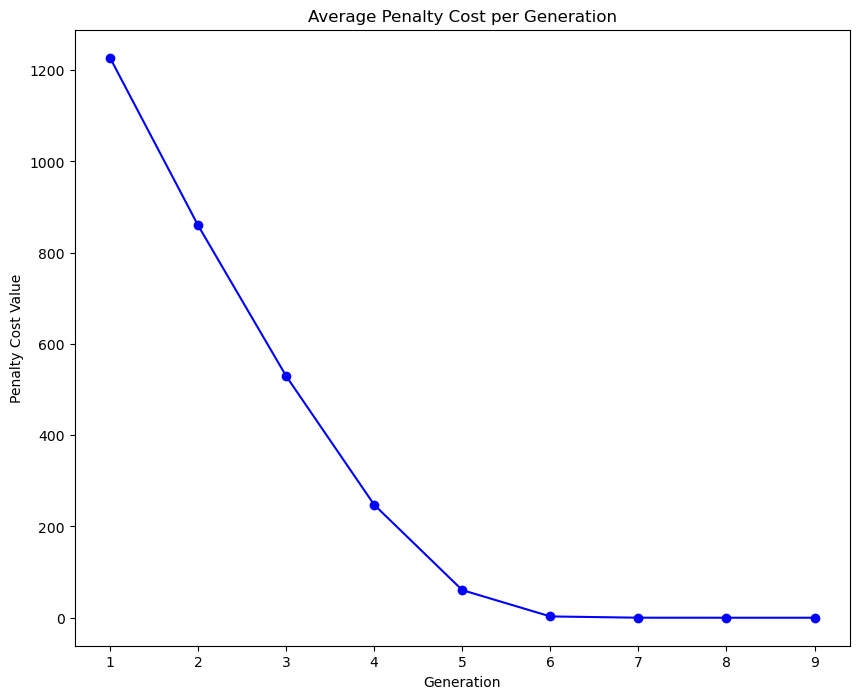

In [71]:
# History AVG
plt.figure(figsize=(10, 8))
front = np.array([(c['gen'], c['avg'][0]) for c in logbook])
plt.plot(front[:, 0][1:-1], front[:, 1][1:-1], "-bo", c="b")
plt.xlabel('Generation')  # X-axis label
plt.ylabel('Penalty Cost Value')  # Y-axis label
plt.title('Average Penalty Cost per Generation')  # Plot title
plt.axis("tight")
plt.show()

In [72]:
import pandas as pd

def count_teams_starting_each_day(schedule_df):
    # Initialize a dictionary to hold the count of teams starting work each day
    days_count = {day: 0 for day in range(1, PLANNING_HORIZON * 2 + 1)}

    # Iterate through each row in the DataFrame
    for index, row in schedule_df.iterrows():
        start_day = row['start_maintenance']
        if start_day in days_count:
            days_count[start_day] += 1

    # Convert the dictionary to a pandas DataFrame for better readability
    days_count_df = pd.DataFrame(list(days_count.items()), columns=['Day', 'Teams_Starting'])
    
    return days_count_df

# Assume schedule_df is the DataFrame containing the maintenance schedule
schedule_df = pd.DataFrame(best_solution)  # best_solution should be a list of dictionaries
days_count_df = count_teams_starting_each_day(schedule_df)

print(days_count_df)


    Day  Teams_Starting
0     1               0
1     2               0
2     3               2
3     4               0
4     5               0
5     6               1
6     7               0
7     8               1
8     9               1
9    10               1
10   11               0
11   12               0
12   13               0
13   14               0
14   15               0
15   16               0
16   17               1
17   18               0
18   19               0
19   20               2
20   21               1
21   22               0
22   23               0
23   24               0
24   25               0
25   26               0
26   27               0
27   28               0
28   29               0
29   30               0
30   31               0
31   32               0
32   33               0
33   34               0
34   35               0
35   36               0
36   37               0
37   38               0
38   39               0
39   40               0
40   41         

In [73]:
def count_repairs_per_engine(schedule_df):
    # Count occurrences of each engine_id
    repair_counts = schedule_df['engine_id'].value_counts().reset_index()
    repair_counts.columns = ['engine_id', 'Repair_Count']

    return repair_counts

# Assume schedule_df is the DataFrame containing the maintenance schedule
schedule_df = pd.DataFrame(best_solution)  # best_solution should be a list of dictionaries

# Count repairs per engine
repair_counts_df = count_repairs_per_engine(schedule_df)
print(repair_counts_df)

   engine_id  Repair_Count
0         76             3
1         56             3
2         68             3
3         81             1
